In [33]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import * 
from pyspark.sql.types import *

ModuleNotFoundError: No module named 'squarify'

In [2]:
schema = StructType([
    StructField("request_id", IntegerType(), True),
    StructField("borough", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("hour", IntegerType(), True),
    StructField("minute", IntegerType(), True),
    StructField("traffic_volume", IntegerType(), True),
    StructField("segment_id", IntegerType(), True),
    StructField("geometry", StringType(), True),
    StructField("on_street", StringType(), True),
    StructField("from_street", StringType(), True),
    StructField("to_street", StringType(), True),
    StructField("traffic_direction", StringType(), True),
])

In [5]:
# Define the path to your CSV file in Google Cloud Storage
file_path = "gs://data-system-architecture-final-project/final_nyc_automated_traffic_volume/Automated_Traffic_Volume_Counts.csv"

# Read the CSV file into a Spark DataFrame
traffic_df = spark.read.csv(file_path, header=True, schema = schema)

In [6]:
traffic_df.persist()

DataFrame[request_id: int, borough: string, year: int, month: int, day: int, hour: int, minute: int, traffic_volume: int, segment_id: int, geometry: string, on_street: string, from_street: string, to_street: string, traffic_direction: string]

In [7]:
# doing transformation of dataframe renaming column
traffic_df = traffic_df.withColumnRenamed("borough","administrive_division")

In [8]:
traffic_df.printSchema()

root
 |-- request_id: integer (nullable = true)
 |-- administrive_division: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- traffic_volume: integer (nullable = true)
 |-- segment_id: integer (nullable = true)
 |-- geometry: string (nullable = true)
 |-- on_street: string (nullable = true)
 |-- from_street: string (nullable = true)
 |-- to_street: string (nullable = true)
 |-- traffic_direction: string (nullable = true)



In [9]:
#data tarnsformation

# Drop the columns that are not required for analysis
columns_to_drop = ['request_id', 'minute', 'segment_id', 'geometry', 'traffic_direction']
traffic_df = traffic_df.drop(*columns_to_drop)

# Convert 'month' to month short name
traffic_df = traffic_df.withColumn(
    'month',
    when(traffic_df['month'] == 1, 'Jan')
    .when(traffic_df['month'] == 2, 'Feb')
    .when(traffic_df['month'] == 3, 'Mar')
    .when(traffic_df['month'] == 4, 'Apr')
    .when(traffic_df['month'] == 5, 'May')
    .when(traffic_df['month'] == 6, 'Jun')
    .when(traffic_df['month'] == 7, 'Jul')
    .when(traffic_df['month'] == 8, 'Aug')
    .when(traffic_df['month'] == 9, 'Sep')
    .when(traffic_df['month'] == 10, 'Oct')
    .when(traffic_df['month'] == 11, 'Nov')
    .when(traffic_df['month'] == 12, 'Dec')
    .otherwise('Unknown')
)

# Transform 'hour' to 12-hour clock format with AM/PM
transformed_df = traffic_df.withColumn('hour_description', 
                                       when(col('hour') < 12, concat(col('hour').cast('string') , lit(' AM')))
                                       .otherwise( concat((col('hour') - 12).cast('string') , lit(' PM'))))

# Group by and aggregate
aggregated_df = transformed_df.groupBy(
    'administrive_division', 'year', 'month', 'day', 'hour_description', 'on_street', 'from_street', 'to_street'
).agg(
    sum('traffic_volume').alias('total_traffic_volume')
)


In [11]:
# Group by 'hour' and sum 'total_traffic_volume'
hourly_traffic_df = aggregated_df.groupBy('hour_description').agg(sum('total_traffic_volume').alias('hourly_traffic'))
print("Displaying total traffic volume by hour")
hourly_traffic_df.show()

Displaying total traffic volume by hour


+----------------+--------------+
|hour_description|hourly_traffic|
+----------------+--------------+
|            6 PM|     173079354|
|            8 PM|     135988548|
|            7 AM|     141172003|
|            7 PM|     156429493|
|            0 AM|      67435252|
|            6 AM|     102857462|
|            1 PM|     157900020|
|           11 AM|     146907940|
|           10 AM|     141893861|
|            4 AM|      36723152|
|           11 PM|      88880212|
|           10 PM|     105730341|
|            2 AM|      35187807|
|            9 PM|     119175867|
|            3 AM|      30597151|
|            5 PM|     180668921|
|            9 AM|     144709638|
|            8 AM|     152414379|
|            3 PM|     178534300|
|            2 PM|     169243591|
+----------------+--------------+
only showing top 20 rows



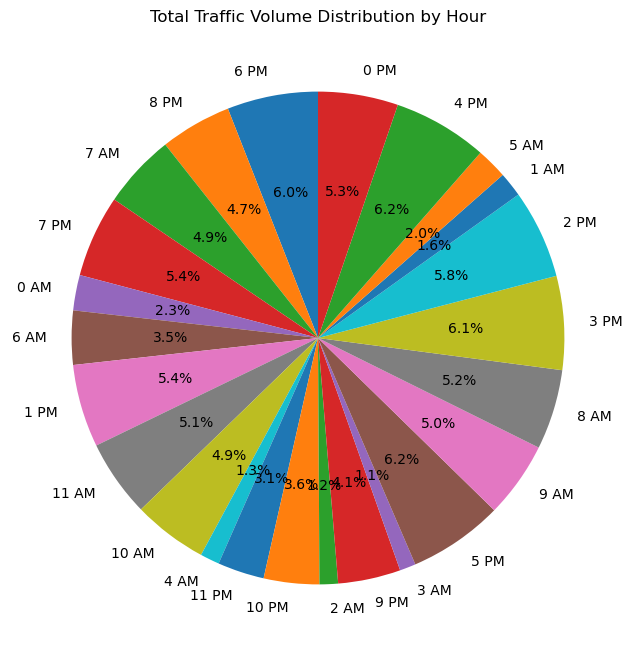

In [13]:
# Convert Spark DataFrame to Pandas
hourly_traffic_pandas = hourly_traffic_df.toPandas()

# Calculate percentage
hourly_traffic_pandas['percentage'] = (hourly_traffic_pandas['hourly_traffic'] / hourly_traffic_pandas['hourly_traffic'].sum()) * 100

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(hourly_traffic_pandas['percentage'], labels=hourly_traffic_pandas['hour_description'], autopct='%1.1f%%', startangle=90)
plt.title('Total Traffic Volume Distribution by Hour')
plt.show()

In [25]:
# Grouping by 'administrative_division' and doing sum 'total_traffic_volume'
division_traffic_df = aggregated_df.groupBy('administrive_division').agg(
    sum('total_traffic_volume').alias('total_traffic')
)
division_traffic_df = division_traffic_df.withColumn(
    'total_traffic_round_off',
    concat(format_number(lit(round(col('total_traffic')/1e6, 0)),0), lit(' million'))
)


print("The administrive division by traffic")
# printing the administrive division by traffic
division_traffic_df.show()

The administrive division by traffic


+---------------------+-------------+-----------------------+
|administrive_division|total_traffic|total_traffic_round_off|
+---------------------+-------------+-----------------------+
|               Queens|    754511305|            755 million|
|             Brooklyn|    660303178|            660 million|
|        Staten Island|    115502854|            116 million|
|            Manhattan|    887509145|            888 million|
|                Bronx|    486654913|            487 million|
+---------------------+-------------+-----------------------+



In [15]:
pandas_df = division_traffic_df.toPandas()

# Round 'total_traffic_division' to the nearest million
pandas_df['total_traffic_division'] = pandas_df['total_traffic_division'].round(-6)

# Plot a bar graph
plt.figure(figsize=(12, 6))
plt.bar(pandas_df['administrive_division'], pandas_df['total_traffic_division'], color='blue')
plt.xlabel('Administrative Division')
plt.ylabel('Total Traffic Volume (Nearest Million)')
plt.title('Total Traffic Volume by Administrative Division')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

+---------------------+----------------------+
|administrive_division|total_traffic_division|
+---------------------+----------------------+
|               Queens|             754511305|
|             Brooklyn|             660303178|
|        Staten Island|             115502854|
|            Manhattan|             887509145|
|                Bronx|             486654913|
+---------------------+----------------------+



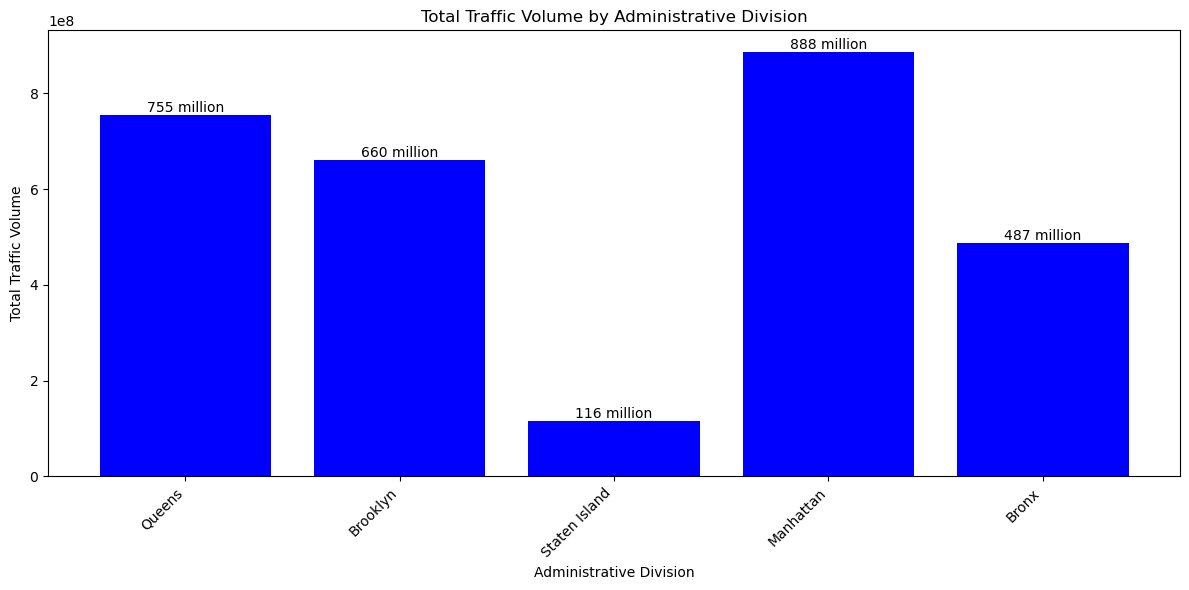

In [26]:
division_traffic_pandas = division_traffic_df.toPandas()

# Plot a bar graph
fig, ax = plt.subplots(figsize=(12, 6))
bar_plot = ax.bar(division_traffic_pandas['administrive_division'], division_traffic_pandas['total_traffic'], color='blue')
ax.set_xlabel('Administrative Division')
ax.set_ylabel('Total Traffic Volume')

# Display the 'total_traffic_round_off' above each bar
for rect, label in zip(bar_plot, division_traffic_pandas['total_traffic_round_off']):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2.0, height, label, ha='center', va='bottom')

plt.title('Total Traffic Volume by Administrative Division')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
# Grouping by 'year' and sum 'total_traffic_volume'
yearly_traffic_df = aggregated_df.groupBy('year').agg(
    sum('total_traffic_volume').alias('total_traffic_yearly')
)

# Add a column 'total_traffic_yearly_round_off' rounding 'total_traffic_yearly' to the nearest million
# and formatting it as a string with ' million'
yearly_traffic_df = yearly_traffic_df.withColumn(
    'total_traffic_yearly_round_off',
    concat(format_number(round(col('total_traffic_yearly') / 1e6, 0), 0), lit(' million'))
)

print("Total traffic by year")
# Show the new DataFrame
yearly_traffic_df.show(truncate=False)

Total traffic by year


+----+--------------------+------------------------------+
|year|total_traffic_yearly|total_traffic_yearly_round_off|
+----+--------------------+------------------------------+
|2007|3587668             |4 million                     |
|2018|204215992           |204 million                   |
|2015|363502411           |364 million                   |
|2006|486569              |0 million                     |
|2013|285701362           |286 million                   |
|2014|410963919           |411 million                   |
|2019|251705123           |252 million                   |
|2020|44937164            |45 million                    |
|2012|264576184           |265 million                   |
|2009|86558368            |87 million                    |
|2016|374916342           |375 million                   |
|2000|243762              |0 million                     |
|2010|140333829           |140 million                   |
|2011|132260674           |132 million                  

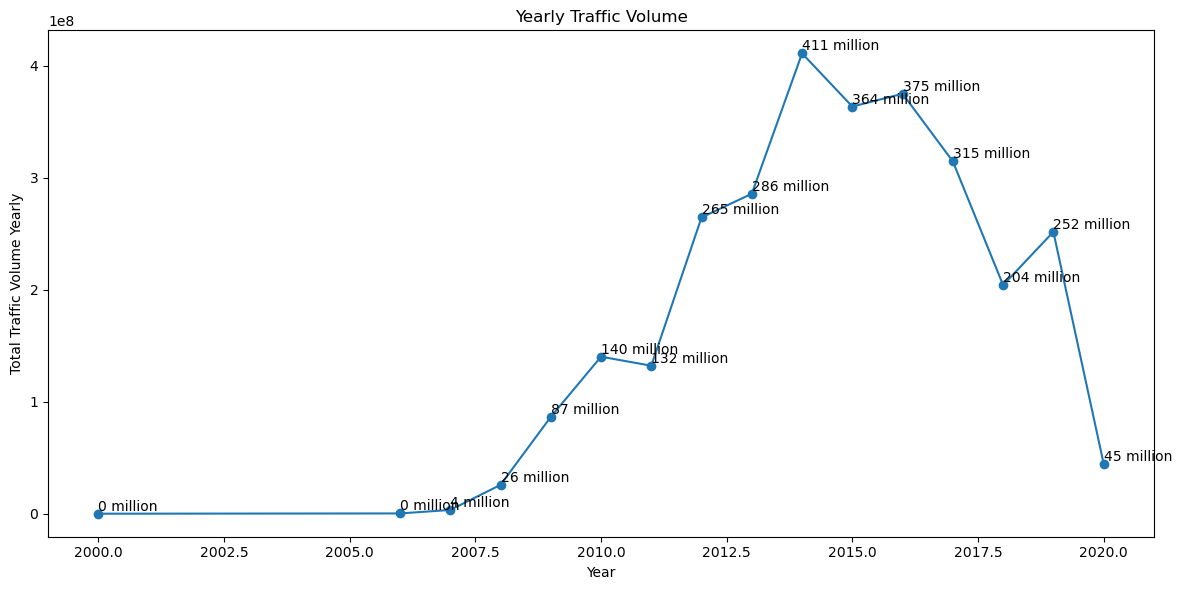

In [29]:
# Convert PySpark DataFrame to Pandas DataFrame
yearly_traffic_pandas = yearly_traffic_df.toPandas()

# Sort the Pandas DataFrame by 'year' in ascending order
yearly_traffic_pandas = yearly_traffic_pandas.sort_values(by='year')

# Plot a line graph
fig, ax = plt.subplots(figsize=(12, 6))
line_plot = ax.plot(yearly_traffic_pandas['year'], yearly_traffic_pandas['total_traffic_yearly'], marker='o', linestyle='-')
ax.set_xlabel('Year')
ax.set_ylabel('Total Traffic Volume Yearly')

# Display the data label points with 'total_traffic_yearly_round_off'
for year, traffic, label in zip(yearly_traffic_pandas['year'], yearly_traffic_pandas['total_traffic_yearly'], yearly_traffic_pandas['total_traffic_yearly_round_off']):
    ax.text(year, traffic, label, ha='left', va='bottom')

plt.title('Yearly Traffic Volume')
plt.tight_layout()
plt.show()

In [31]:
# Group by 'on_street' and sum 'total_traffic_volume'
street_traffic_df = aggregated_df.groupBy('on_street').agg(
    sum('total_traffic_volume').alias('total_traffic')
)

# Rename the 'on_street' column to 'street'
street_traffic_df = street_traffic_df.withColumnRenamed('on_street', 'street')

# Perform descending sort by 'total_traffic_street'
street_traffic_df = street_traffic_df.orderBy('total_traffic', ascending=False)

# Limit the results to the top 10
top_10_busiest_street_df = street_traffic_df.limit(10)

# Show the top 10 streets with the highest total traffic
top_10_busiest_street_df.show(truncate=False)

+----------------------+-------------+
|street                |total_traffic|
+----------------------+-------------+
|BROADWAY              |58131038     |
|2 AVENUE              |34873797     |
|F D R DRIVE           |30538964     |
|LONG ISLAND EXPRESSWAY|27240754     |
|BELT PARKWAY          |26475866     |
|GRAND CENTRAL PARKWAY |25933347     |
|NORTHERN BOULEVARD    |25776591     |
|3 AVENUE              |25631051     |
|QUEENS BOULEVARD      |24486610     |
|WOODHAVEN BOULEVARD   |22756894     |
+----------------------+-------------+



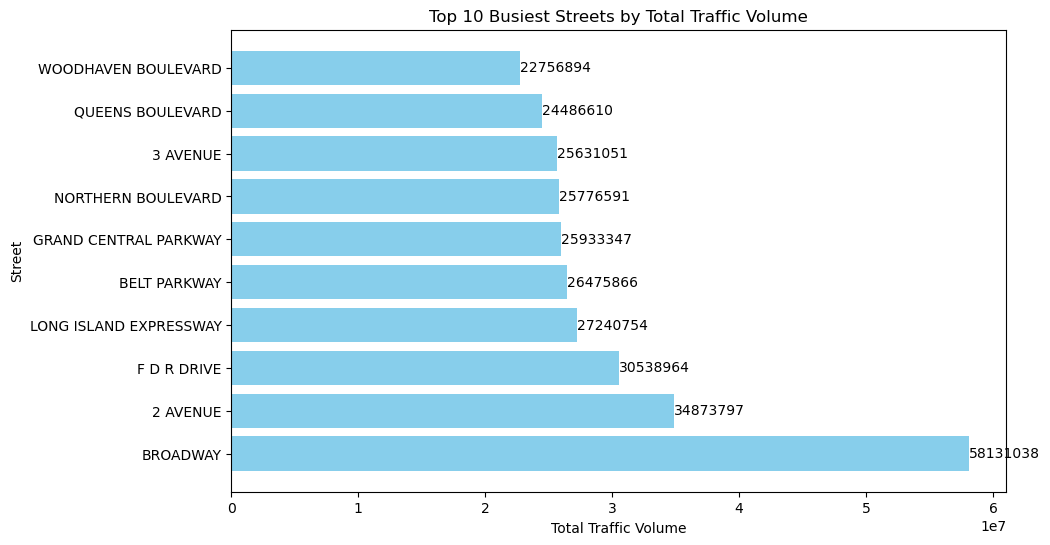

In [38]:
# Convert Spark DataFrame to Pandas DataFrame
top_10_busiest_street_pandas = top_10_busiest_street_df.toPandas()

# Plot Horizontal Bar Chart with Data Labels
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_10_busiest_street_pandas['street'], top_10_busiest_street_pandas['total_traffic'], color='skyblue')

# Add data labels to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             str(int(bar.get_width())), ha='left', va='center', fontsize=10)

ax.set_xlabel('Total Traffic Volume')
ax.set_ylabel('Street')
ax.set_title('Top 10 Busiest Streets by Total Traffic Volume')
plt.show()